<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cosmos-HST" data-toc-modified-id="Cosmos-HST-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cosmos HST</a></span></li></ul></div>

# Cosmos HST

Check coverage of grizli-processed HST imaging in COSMOS

In [1]:
import os
import numpy as np
from grizli import utils

In [2]:
tab = utils.read_catalog('cosmos_HST_exposure_catalog_2020.03.09.fits')
xfootprints = np.load('cosmos_HST_exposure_catalog_2020.03.09_footprints.npy', 
                     allow_pickle=True)

# Data format issue
footprints = [[fp[0], fp[1]] for fp in xfootprints]

In [3]:
import astropy.units as u

def check_hst_overlaps(ra, dec, tab, footprints, label=None, sep=3*u.arcmin):
    """
    Check overlapping HST exposures at a given position
    """
    #sep = 10*u.arcmin
    from grizli import utils
    
    from matplotlib.patches import PathPatch
    from matplotlib.path import Path
    import matplotlib.pyplot as plt
    
    this = utils.GTable()
    this['ra'] = [ra]
    this['dec'] = [dec]

    idx, dr = this.match_to_catalog_sky(tab)
    near = dr < sep

    fig, ax = plt.subplots(1,1,figsize=(5,5))
    if label is None:
        label = f'{ra:.6f} {dec:.6f}'
        
    ax.scatter([ra], [dec],  color='r', marker='*', zorder=100, label=label)
    ax.scatter(tab['ra'][near], tab['dec'][near], marker='+', color='0.8')

    in_patch = near & True

    for i in np.where(near)[0]:
        path = Path(np.array(footprints[i]).T)
        in_path = path.contains_point((ra, dec))
        if in_path:
            patch = PathPatch(path, color='orange', alpha=0.2)
        else:
            patch = PathPatch(path, color='k', alpha=0.1)
            in_patch[i] = False

        ax.add_patch(patch)
    
    cosd = np.cos(dec/180*np.pi)
    ax.set_aspect(1/cosd)
    ax.grid()
    ax.legend(loc='upper center')
    ax.set_xlim(*ax.get_xlim()[::-1])
    
    fig.tight_layout(pad=0.5)
    
    return fig, in_patch

In [4]:
# Kriek et al. massive galaxy
ra, dec = 150.07393, 2.2980

# No filter preselection
sel_filts = None 

# Limit filters
sel_filts = ['f160w']

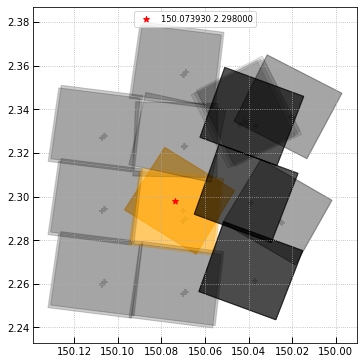

In [5]:
if sel_filts is not None:
    sel = np.zeros(len(tab), dtype=bool)
    for f in sel_filts:
        sel |= tab['filter'] == f
    
    sel = np.where(sel)[0]
    tab_sel = tab[sel]
    fp_sel = [footprints[i] for i in sel]
    
else:
    tab_sel = tab
    fp_sel = footprints
    
_fig, _sel = check_hst_overlaps(ra, dec, tab_sel, fp_sel, sep=4*u.arcmin)

In [6]:
tab_sel[_sel]

ra,dec,file,filter,root
deg,deg,,,
float64,float64,bytes18,bytes6,bytes57
150.07008553622828,2.293237871189638,ibhg01k2q_flt.fits,f160w,j100028p0214_0000_bhg_cos7712_wfc3ir_f160w
150.0699313110156,2.2931998906533417,ibhg01k3q_flt.fits,f160w,j100028p0214_0000_bhg_cos7712_wfc3ir_f160w
150.06993266857899,2.2932987335726005,ibhg01k4q_flt.fits,f160w,j100028p0214_0000_bhg_cos7712_wfc3ir_f160w
150.07008685502765,2.2933366721988113,ibhg01k5q_flt.fits,f160w,j100028p0214_0000_bhg_cos7712_wfc3ir_f160w
150.0699905066064,2.288647196559313,iboa22eiq_flt.fits,f160w,j100028p0214_0022_boa_cosmos-v22_wfc3ir_f160w
150.07023401856912,2.2886595205890883,iboa22emq_flt.fits,f160w,j100028p0214_0022_boa_cosmos-v22_wfc3ir_f160w
150.06885201971357,2.289813791056362,iboa66pjq_flt.fits,f160w,j100028p0214_0066_boa_cosmos-v66_wfc3ir_f160w
150.06909539407735,2.2898284661604995,iboa66pnq_flt.fits,f160w,j100028p0214_0066_boa_cosmos-v66_wfc3ir_f160w


In [7]:
# Exposures
url = 'https://s3.amazonaws.com/cosmos-dash/Pipeline/{root}/Prep/{file}'

i = 0
url_i = url.format(root=tab_sel[_sel]['root'][i], file=tab_sel[_sel]['file'][i])
#os.system('wget ')
print(url_i)

https://s3.amazonaws.com/cosmos-dash/Pipeline/j100028p0214_0000_bhg_cos7712_wfc3ir_f160w/Prep/ibhg01k2q_flt.fits


In [8]:
# Fetch data
if False:
    os.system(f'wget {url_i}')